# Fase 2: Diagnóstico y calidad de los datos

El objetivo es ~~modificar~~ obtener el dataset (original) tratando aquellos datos que puedan derivar conclusiones erróneas o sesgadas.

En esta fase las tareas se enfocan en revisar el _dataset_, identificando y tratando:
- Registros duplicados
- Disminuir la cardinal de aquellas variables que no aportan diferenciación significativa
- Detectar y tratar _outliers_
- Registros erróneos, inexistente o incompletos

## Tratamiento de registros duplicados

Esta tarea tiene como propósito:
- Asegurar que los datos que no están duplicados.
- Asegurarse que las columnas no tengan un alto numero de duplicados, ya que pueden no aportar información.

In [1]:
import pandas as pd

vehiculos = pd.read_csv("./output/vehiculos-1-procesado_inicial.csv") # datos
vehiculos.head(5)

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,rendimiento,co2
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
1,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
3,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500


Generar en el _dataset_ una entidad (variable auxiliar) que permita detectar registros duplicados. Recordando que la entidad unica esta formada de la combinación: `fabricante + modelo + año`.

[Series.str.cat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.cat.html), [Series.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html)

In [2]:
vehiculos['modelo_unico'] = vehiculos['fabricante'].str.cat([vehiculos['modelo'], vehiculos['year'].apply(str)],sep='-')
vehiculos.modelo_unico.value_counts() # contador de entidades

Jeep-Cherokee/Wagoneer-1985               24
Ford-F150 Pickup 2WD-1984                 19
GMC-C15 Pickup 2WD-1984                   19
Chevrolet-C10 Pickup 2WD-1984             19
GMC-C15 Pickup 2WD-1985                   18
                                          ..
Mercedes-Benz-C300-2015                    1
Mercedes-Benz-C300-2009                    1
Mercedes-Benz-C280 4matic-2007             1
Mercedes-Benz-C280 4matic-2006             1
smart-fortwo electric drive coupe-2016     1
Name: modelo_unico, Length: 17448, dtype: int64

Una revisión básica (definición de la entidad), permite identificar varias entidades duplicadas. 
- Un análisis más exahustivo permite detectar si efectivamente los datos están duplicados o existe un número mayor de atributos que complementan la definición de las entidades. Por ejemplo, para uno de la `Chevrolet-C1500 Pickup 2WD-1991` encontramos el siguiente detalle:

In [3]:
vehiculos[vehiculos.modelo_unico=='Chevrolet-C1500 Pickup 2WD-1991'].head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,rendimiento,co2,modelo_unico
4957,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Automatic 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4958,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4959,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 5-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4960,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 5-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4961,Chevrolet,C1500 Pickup 2WD,1991,5.0,8.0,Automatic 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,15,592.466667,Chevrolet-C1500 Pickup 2WD-1991


En el detalle, cada modelo único tiene diferentes configuraciones de cada vehículo, por ejemplo, transmisión de 4 o 5 velocidades.

Por lo tanto, para este caso, se definen como duplicados aquellos registros que sean idénticos en todas sus columnas.

[DataFrame.duplicated()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html) verifica la cantidad de registros duplicados.

In [4]:
vehiculos[vehiculos.duplicated()].shape

(1506, 12)

De acuerdo a la consulta se identifican 1506 registros duplicados, por lo tanto son eliminados del análisis debido a que podrían generar sesgos en las conclusiones.

[DataFrame.drop_duplicates()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html) retorna los registros unicos, eliminando los registros diplicados.

In [5]:
vehiculos = vehiculos.drop_duplicates()
vehiculos.shape

(36930, 12)

A continuación, se elimina la columna auxiliar `modelo_unico` (usada para detectar duplicados).

In [6]:
del vehiculos['modelo_unico']

La siguiente tarea, consiste en identifcar las variables cuyos registros contengan el mismo valor (cardinalidad).

In [7]:
def duplicados_por_columna(df):
    registros = len(df)
    for columna in df:
        frecuencia_columna = df[columna].value_counts()
        max_columna = frecuencia_columna.iloc[0]
        min_columna = frecuencia_columna.iloc[-1]
        print('{} > {} > {}'.format(
            round(max_columna/registros, 3),
            columna,
            round(min_columna/registros, 3))
            )

duplicados_por_columna(vehiculos)

0.1 > fabricante > 0.0
0.005 > modelo > 0.0
0.038 > year > 0.007
0.095 > desplazamiento > 0.0
0.38 > cilindros > 0.0
0.287 > transmision > 0.0
0.353 > traccion > 0.005
0.145 > clase > 0.0
0.652 > combustible > 0.0
0.097 > rendimiento > 0.0
0.084 > co2 > 0.0


Las variables `traccion`, `transmision`, `cilindros` y `combustible` podrían estar repetidos, sin embargo, un 30% no es algo muy significativo (para el dominio), sería distinto si el valor más común tuviera un 90%.

Mayor detalle de cada variable (columna) puede ser analizada contando valores (absolutos).

In [8]:
vehiculos['traccion'].value_counts()

Front-Wheel Drive             13018
Rear-Wheel Drive              12750
4-Wheel or All-Wheel Drive     6408
All-Wheel Drive                2252
4-Wheel Drive                  1116
2-Wheel Drive                   412
Part-time 4-Wheel Drive         177
Name: traccion, dtype: int64

También es posible obtener un resultado normalizado (relación respecto del total, %).

In [9]:
vehiculos['traccion'].value_counts(normalize=True)

Front-Wheel Drive             0.360280
Rear-Wheel Drive              0.352863
4-Wheel or All-Wheel Drive    0.177345
All-Wheel Drive               0.062325
4-Wheel Drive                 0.030886
2-Wheel Drive                 0.011402
Part-time 4-Wheel Drive       0.004899
Name: traccion, dtype: float64

En este caso, un experto o con [conocimiento de dominio](https://www.edmunds.com/car-technology/what-wheel-drive.html), podría concluir que probablemente la tracción `2-Wheel Drive` es simplemente una clasificacion distinta de `Front` o `Rear`. 

__NOTA__: Es útil utilizar gráficos para la identificación de cardinalidad.

En relación con el atributo `transmision`:

<AxesSubplot:>

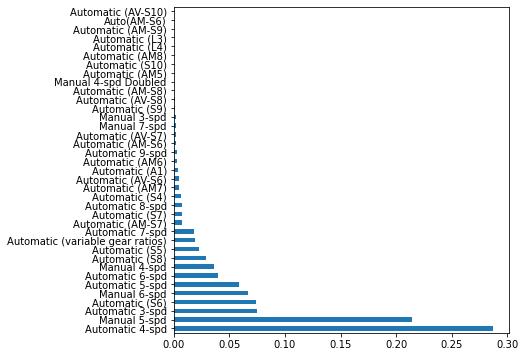

In [10]:
import matplotlib.pyplot as plt

# configurar parámetros de las gráficas
plt.rcParams['figure.figsize'] = (6, 6) # 7x7 pulgadas para todos los plots

vehiculos['transmision'].value_counts(normalize=True).plot.barh()

Aunque `transmision` tenga una cardinalidad relativamente alta, en realidad muestra una distribución de tipos, con dos clases mayoritarias.

En relación con el atributo `cilindros`:

<AxesSubplot:>

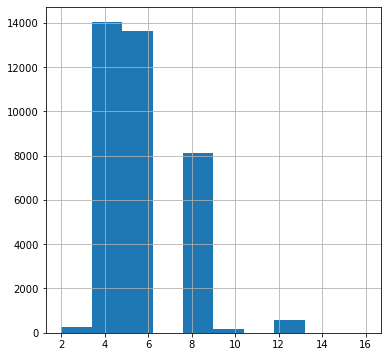

In [11]:
vehiculos['cilindros'].hist()

En relación con el atributo `combustible`:

<AxesSubplot:>

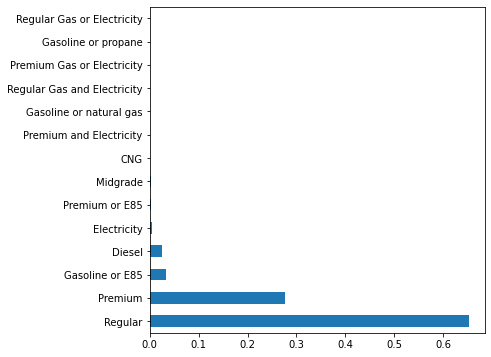

In [12]:
vehiculos['combustible'].value_counts(normalize=True).plot.barh()

Se identifica que el atributo `combustible` podría alertar un posible problema en el _dataset_ al mostrar un 65% de los casos con combustible `Regular`.

## Tratamiento de valores atípicos (_outliers_)

Para detectar valores extremos, una medida general es considerar _outliers_ a aquellos valores con una puntuación $z$ (_z-score_) mayor que 3, i.e., aquellos valores que se alejan 3 veces o más desviaciones estándar de la media.

El _z-score_ de una medición $x$ se define como:

\begin{equation*}
z(x)= \frac{x-\mu}{\sigma}
\end{equation*}

donde, $\mu$ y $\sigma$ es la media y la desviación estándar, respectivamente. El _z-score_ índica la cantidad de $\sigma$ que una medición se encuentra alejada de la media.

- [scipy.stats.zscore](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html)

__IMPORTANTE__: La función [scipy.stats.zscore](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) no opera adecuadamente con registros nulos. Para usarla, se sugiere verificar la existencia de registros nulos.

In [13]:
import numpy as np

def media(series):
    return series.sum() / len(series)

def desviacion_estandar(series):
    cuadrados = (series - media(series)) ** 2
    return ( cuadrados.sum() / (len(series)) ) ** 0.5

def z_score(series):
    return (series - media(series)) / desviacion_estandar(series)

def outliers_by_col(dframe, desviaciones=1):
    for col in dframe:
        if dframe[col].dtype != object:
            outliers = len(dframe[abs(z_score(dframe[col])) > desviaciones])
            print("{:5}: {} ({})".format(outliers, dframe[col].name, dframe[col].dtype))

In [14]:
outliers_by_col(vehiculos, 3)

    0: year (int64)
   47: desplazamiento (float64)
  583: cilindros (float64)
  233: rendimiento (int64)
  358: co2 (float64)


Los diagramas de cajas (_box plot_) permiten detectar de forma gráfica _outliers_. Para este caso, las variables `cilindros`, `desplazamientos`, `rendimiento` y `emision-co2` tienen _outliers_. Para recordar, en el diagrama,
- La línea central de la caja representa la mediana.
- La línea inferior de la caja corresponde al primer cuartil.
- La línea superior de la caja corresponde al tercer cuartil.
- Las líneas inferior y superior corresponden mínimos y máximos, respectivamente.
- Los puntos son los _outliers_.

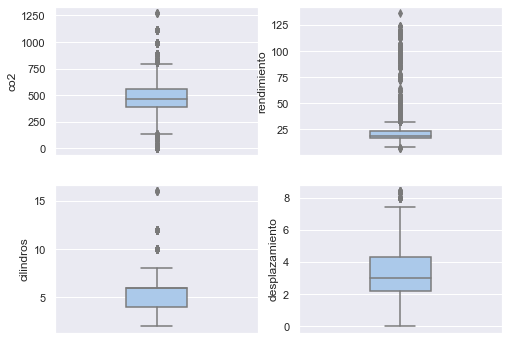

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(palette='pastel') # Setting seaborn as default style even if use only matplotlib
fig, axes = plt.subplots(2, 2, figsize=(8,6))
bplot = sns.boxplot(ax=axes[0,0], data=vehiculos, y='co2', width=.3)
bplot = sns.boxplot(ax=axes[0,1], data=vehiculos, y='rendimiento', width=.3)
bplot = sns.boxplot(ax=axes[1,0], data=vehiculos, y='cilindros', width=.3)
bplot = sns.boxplot(ax=axes[1,1], data=vehiculos, y='desplazamiento', width=.3)

De acuerdo con las gráficas (`co2` y `rendimiento`), la carcaterización de los datos, muestra que:

- Algunos vehículos que contaminan más de lo normal y otros que contaminan menos de lo normal, tambien se identifica que existen vehículos que no contaminan.
- Existen vehículos que tienen rendimiento por sobre la media, mientras que otros que tienen un rendimiento bajo de la media.

Para explicar el comportamiento de los valores atípicos, a continuación se identifica que, los vehículos que no contaminan (`co2 = 0`) utilizan como combustible la electricidad.

In [16]:
vehiculos[vehiculos['co2'] == 0]['combustible'].unique()

array(['Electricity'], dtype=object)

Para __verificar__ que los valores detectados son _outliers_, se evalua la existencia de estos últimos en el subconjunto de vehículos contaminantes (`co2 > 0`), es decir, equellos vehiculos que no son eléctricos.

In [17]:
no_electricos = vehiculos[ vehiculos['co2'] > 0 ]
outliers_by_col(no_electricos, 3)

    0: year (int64)
   43: desplazamiento (float64)
  583: cilindros (float64)
  400: rendimiento (int64)
  221: co2 (float64)


Considerando que aún existen valores atípicos, se realiza un análisis de dos subconjunto de vehiculos: 

- muy contaminantes, puntuación $z(x) > 3$
- poco contaminantes, puntuación $z(x) < -3$ 

In [30]:
no_electricos['z-score'] = z_score(vehiculos['co2'])
muy_contaminates = no_electricos[no_electricos['z-score'] > 3]
muy_contaminates['combustible'].value_counts()

/opt/miniconda3/envs/eda37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Regular                    131
Premium                     68
Gasoline or natural gas      1
Name: combustible, dtype: int64

In [31]:
poco_contaminates = no_electricos[no_electricos['z-score'] < -3]
poco_contaminates['combustible'].value_counts()

Premium Gas or Electricity     13
Regular Gas and Electricity     4
Regular Gas or Electricity      2
Name: combustible, dtype: int64

Los resultados muestran que los vehículos más contaminantes utilizan gasolina, mientras que los menos contaminantes son híbridos. Por lo tanto, pareciera que los valores atípicos detectados, no lo son. Sin embargo, si se decide filtrar de acuerdo al criterio $3\sigma$,

In [33]:
vehiculos_sin_outliers = vehiculos[( abs(z_score(vehiculos['co2'])) < 3 )]
outliers_by_col(vehiculos_sin_outliers, 3)

    0: year (int64)
   30: desplazamiento (float64)
  535: cilindros (float64)
  386: rendimiento (int64)
   13: co2 (float64)


Removidos los _outliers_, cambia la distribución del _dataset_. Luego, se verificar la existencia de _outliers_ y se vuelven a eliminar,

In [34]:
vehiculos_sin_outliers = vehiculos_sin_outliers[( abs(z_score(vehiculos_sin_outliers['co2'])) < 3 )]
outliers_by_col(vehiculos_sin_outliers, 3)

    0: year (int64)
   30: desplazamiento (float64)
  535: cilindros (float64)
  375: rendimiento (int64)
    0: co2 (float64)


## Tratamiento de valores inexistentes

Los valores inexistentes podrían ser válidos o invalidos. Es importante, separar estos dos tipos. Por ejemplo, un valor inexistente inválido sería la falta de un apellido de una persona de nacionalidad chilena, sin embargo, para un estadounidense, la inexistencia de su segundo apellido sería válido.

Por otra parte, muchos algoritmos de _Machine Learning_ requieren que no existan valores inexistentes (o `NaN`) en el _dataset_. Algunas técnicas para tratar dichos valores consisten en,

- Eliminar registros con valores nulos.
- Reemplazar o imputar los valores nulos.
- Usar un modelo predictivo para predecir los valores inexistentes, a partir de registros anteriores.
- [Multivariate imputation by chained equations (MICE)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/) ([implementaciones](https://github.com/iskandr/fancyimpute)).
- [Otras estrategias](https://gallery.cortanaintelligence.com/Experiment/Methods-for-handling-missing-values-1).


In [37]:
def nulls_by_col(dframe):
    for col in dframe:
        print("{:5}: {} ({})".format(
            len( dframe[ dframe[col].isnull() ] ),
            dframe[col].name,
            dframe[col].dtype
            ))

nulls_by_col(vehiculos)

    0: fabricante (object)
    0: modelo (object)
    0: year (int64)
  140: desplazamiento (float64)
  142: cilindros (float64)
   11: transmision (object)
  797: traccion (object)
    0: clase (object)
    0: combustible (object)
    0: rendimiento (int64)
    0: co2 (float64)


__Eliminar registros__ con valores inexistentes.
- [DataFrame.dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

In [38]:
vehiculos_notnull = vehiculos.dropna(subset=['transmision', 'desplazamiento', 'cilindros', 'traccion'])
nulls_by_col(vehiculos_notnull)

    0: fabricante (object)
    0: modelo (object)
    0: year (int64)
    0: desplazamiento (float64)
    0: cilindros (float64)
    0: transmision (object)
    0: traccion (object)
    0: clase (object)
    0: combustible (object)
    0: rendimiento (int64)
    0: co2 (float64)


__Reemplazar los valores inexistentes con un valor nulo__, por ejemplo, `0` o `nulo`. Es una forma simple de tratar estos valores pero añade _ruido_ a los datos (se asume que los valores que los valores son inexistentes).

In [39]:
vehiculos['transmision_imp'] = vehiculos['transmision'].fillna('sin transmision')
vehiculos['desplazamiento_imp'] = vehiculos['desplazamiento'].fillna(0)
vehiculos['cilindros_imp'] = vehiculos['cilindros'].fillna(0)

In [40]:
vehiculos[ vehiculos['transmision_imp'] == 'sin transmision'].head(2)

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,rendimiento,co2,transmision_imp,desplazamiento_imp,cilindros_imp
13374,Ford,Explorer USPS Electric,2001,NaN,NaN,NaN,2-Wheel Drive,Sport Utility Vehicle - 2WD,Electricity,39,0.0,sin transmision,0.0,0.0
13375,Ford,Explorer USPS Electric,2002,NaN,NaN,NaN,2-Wheel Drive,Sport Utility Vehicle - 2WD,Electricity,39,0.0,sin transmision,0.0,0.0


In [41]:
vehiculos = vehiculos.drop(["transmision_imp", "cilindros_imp", "desplazamiento_imp"], axis=1)

__Reemplazar los valores inexistentes por un valor elegido con criterio específico__. Prácticas comunes de imputacion de datos consiste en reemplazar los valores inexistentes de una variable con su media, moda o mediana.

In [42]:
nulls_by_col(vehiculos)

    0: fabricante (object)
    0: modelo (object)
    0: year (int64)
  140: desplazamiento (float64)
  142: cilindros (float64)
   11: transmision (object)
  797: traccion (object)
    0: clase (object)
    0: combustible (object)
    0: rendimiento (int64)
    0: co2 (float64)


In [44]:
# variables categóricas podría reemplazarse con el valor más frecuente (moda)
transmision_moda = vehiculos['transmision'].mode().values[0] 
traccion_moda = vehiculos['traccion'].mode().values[0]

# variables ordinales, idem
cilindros_moda = vehiculos['cilindros'].mode().values[0]

# variables numéricas podría reemplazarse con la mediana
desplazamiento_mediana = vehiculos['desplazamiento'].median()

# completar datos
vehiculos['traccion'] = vehiculos['traccion'].fillna(traccion_moda)
vehiculos['transmision'] = vehiculos['transmision'].fillna(transmision_moda)
vehiculos['desplazamiento'] = vehiculos['desplazamiento'].fillna(desplazamiento_mediana)
vehiculos['cilindros'] = vehiculos['cilindros'].fillna(cilindros_moda)

nulls_by_col(vehiculos)

    0: fabricante (object)
    0: modelo (object)
    0: year (int64)
    0: desplazamiento (float64)
    0: cilindros (float64)
    0: transmision (object)
    0: traccion (object)
    0: clase (object)
    0: combustible (object)
    0: rendimiento (int64)
    0: co2 (float64)


## Exportar

In [46]:
vehiculos.to_csv("./output/vehiculos-2-limpio_analisis.csv", index=False)